In [1]:
#ok, now we try again.
#-we limit ourselves to 2 dims, on the default
#-and far more importantley, we make it as a group of functional objects
# as in, we have a separate data structure for the voxel plane, 
# then on top of it we make something that eliminates them etc. Every time we extend the basic one, but not change it

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import random

In [3]:
class Voxel:
    def __init__(self,world,pos,size,parent=None):
        self.parent = parent
        self.world = world
        self.pos = pos
        self.size = size
        
        self.subvoxels = np.zeros([2 for i in range(len(self.world.size))]).astype(object)
        self.is_divided = False
        
    def subdivide(self):

        self.is_divided = True
        v_size = self.size / 2
        for index, x in np.ndenumerate(self.subvoxels):
            v_int_pos = tuple(index)
            v_pos = (np.array(index) * v_size) + self.pos
            
            voxel = self.world.voxel_class(self.world,v_pos,v_size,self) 
            self.subvoxels[tuple(index)]= voxel
            
    #returns subvoxel at this position within this voxel        
    def get_subvoxel_from_pos(self,pos):
        if self.is_divided:
            int_pos = tuple(np.floor((pos - self.pos) / (self.size / 2)).astype(int))
            return self.subvoxels[int_pos]
        else:
            return self
     
    #get final subvoxel at this position within this voxel
    def get_final_subvoxel_from_pos(self,pos):
        if self.is_divided:
            voxel = self.get_subvoxel_from_pos(pos)
            return voxel.get_final_subvoxel_from_pos(pos)
        else:
            return self
        
    #returns a list of all final subvoxels within this voxel
    def get_all_final_subvoxels(self):
        
        out =[]
        if self.is_divided:
            for index, x in np.ndenumerate(self.subvoxels):
                out += x.get_all_final_subvoxels()
        else:
            out.append(self)
        return out


    #returns base subvoxels, if there are any, otherwise empty list
    def get_all_base_subvoxels(self):
        out =[]
        for index, x in np.ndenumerate(self.subvoxels):
            #for i in np.nditer(self.subvoxels,flags=["REFS_OK"], op_flags=["readwrite"]):
            out.append(x)
        return out   
    
    #returns a neat list of voxel edges
    def get_all_vertices(self):
        dimlist = [[]]
        for i in range(len(self.size)):
            c_pos = self.pos[i]
            c_size = self.size[i]
            a = [x + [c_pos] for x in dimlist]
            b = [x + [c_pos+c_size] for x in dimlist]
            dimlist = a + b

        return dimlist
        
        
        
        
class World:
    def __init__(self,size,base_voxel_num,voxel_class):
        self.voxel_class = voxel_class
        self.size = np.array(size)
        self.base_voxel_num =np.array(base_voxel_num)
        self.base_voxel_size = self.size / self.base_voxel_num
        self.world = np.zeros(self.base_voxel_num.astype(int)).astype(object)
             
        #creating voxels
        for index, x in np.ndenumerate(self.world):
            v_size = self.base_voxel_size
            v_int_pos = tuple(index)
            v_pos = np.array(index) * v_size
            voxel = voxel_class(self,v_pos,v_size) 
            self.world[tuple(index)]=voxel

    def get_base_voxel_from_pos(self,pos):
        int_pos = tuple(np.floor(pos / self.base_voxel_size).astype(int))
        return self.world[int_pos]   
    
    def get_final_voxel_from_pos(self,pos):
        voxel = self.get_base_voxel_from_pos(pos)
        return voxel.get_final_subvoxel_from_pos(pos)
    
    def get_all_final_voxels(self):
        out =[]
        for index, x in np.ndenumerate(self.world):

            base_voxel = self.world[tuple(index)]
            sbv = base_voxel.get_all_final_subvoxels()

            out += sbv
        return out
            
    def plot(self):
        if len(self.size == 2):
            plt.figure()
            ax = plt.gca()
            ax.set_xlim([0,self.size[0]])
            ax.set_ylim([0,self.size[1]])
            voxel_list = []
            #ax.add_patch(patches.Rectangle((0.1, 0.1), 0.2, 0.2, fill=None, alpha=1))
            for index, x in np.ndenumerate(self.world):
                voxel_list.append(self.world[tuple(index)])
            while len(voxel_list) > 0:
                voxel = voxel_list.pop()
                rect = patches.Rectangle(tuple(voxel.pos),voxel.size[0],voxel.size[1],
                    linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect) 
                if voxel.is_divided:
                    voxel_list += voxel.get_all_base_subvoxels()  
            plt.show()    
        else:
            print("Cannot draw when dimension number != 2")
    

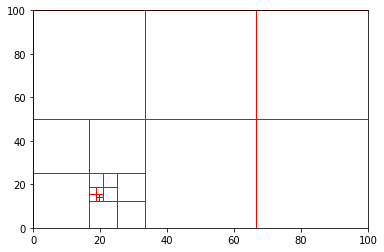

In [4]:
w = World((100.0,100.0),(3,2),Voxel) 
for i in range(5):
    voxel = w.get_final_voxel_from_pos((20.0,15.0))
    voxel.subdivide()
#voxel = w.get_final_voxel_from_pos((20.0,15.0))
#print(voxel.get_all_vertices())
w.plot()

In [5]:
class Figure:
    def __init__(self,pos):
        self.pos = pos
        
    # 1: doesnt overlap, 0: collides but not covers, -1: covers  (given voxel)
    def voxel_overlap(self,voxel):
        return 0
    
    # True: collides, False: not collides (with another figure) 
    def figure_collide(self,figure):
        return False
    
    #draws the figure given the ax
    def draw(self,ax):
        return None

class RSAVoxel(Voxel):
    def __init__(self,world,pos,size,parent=None):
        super().__init__(world,pos,size,parent=None)
        self.is_full = False
        self.contents = []
    
    def subdivide(self):
        if not self.is_full:
            super().subdivide()
            self.world.available_voxels.remove(self)
            subvoxels = self.get_all_base_subvoxels()

            if len(self.contents)  > 0:
                for content in self.contents:
                    for voxel in subvoxels:
                        cond = content.voxel_overlap(voxel)
                        if cond == 0 :
                            voxel.contents.append(content)
                            self.world.available_voxels.append(voxel)

                        elif cond == -1:
                            voxel.contents.append(content)
                            voxel.is_full = True

                        else:
                            self.world.available_voxels.append(voxel)
            else:
                for voxel in subvoxels:
                    self.world.available_voxels.append(voxel)
                    
class RSAWorld(World):
    def __init__(self,size,base_voxel_num,voxel_class,figure_class):
        
        super().__init__(size,base_voxel_num,voxel_class)
            
        self.figure_class = figure_class
        self.available_voxels = []
        self.figures = []
        
        #for index, x in np.ndenumerate(self.world):
        #    self.available_voxels.append(self.world[tuple(index)])
        for index, x in np.ndenumerate(self.world):
            self.available_voxels.append(x)
            
    #checks for collision between new and all figures, and if succesfull, inserts it into the voxels    
    def add_figure(self,pos):
        figure = self.figure_class(pos)
        for i in self.figures:
            if i.figure_collide(figure):
                #break
                return None
            
        new_voxels = self.available_voxels.copy()
        for voxel in self.available_voxels:

            cond = figure.voxel_overlap(voxel)
            if cond == 0:
                voxel.contents.append(figure)       
            elif cond == -1:
                voxel.contents.append(figure)
                voxel.is_full = True  
                new_voxels.remove(voxel)
        self.available_voxels = new_voxels
                
        self.figures.append(figure)
        return figure
                
    def add_random_figure(self):
        if len(self.available_voxels) == 0:
            return None
        #slow, but may be nescesary
        free_voxels = [vox for vox in self.available_voxels if len(vox.contents) == 0]
        if len(free_voxels) > 0:
            voxel = random.choice(free_voxels)
        else:
            voxel = random.choice(self.available_voxels)
        lows = np.array(voxel.pos)
        highs = np.array(voxel.size)
        pos = np.random.uniform(lows,highs,size=len(self.size))
        
        return self.add_figure(pos)
        
    def perform_rsa(self,treshold = 0.1,trials=100):
        while len(self.available_voxels) > 0:
            #for i in range(5):
            count=0
            for i in range(trials):
                fig = self.add_random_figure()
                if fig != None:
                    count+=1
            quality = float(count)/float(trials)
            print(quality,len(self.available_voxels),"count",count,"trials",trials)
            if quality <= treshold:
                avcp = world.available_voxels.copy()
                for i in avcp:
                    if len(i.contents) >0:
                        i.subdivide()
            self.plot()
        
    def plot(self):
        if len(self.size == 2):
            plt.figure(figsize=[16,9])
            ax = plt.gca()
            ax.set_xlim([0,self.size[0]])
            ax.set_ylim([0,self.size[1]])
            voxel_list = self.get_all_final_voxels()
            #ax.add_patch(patches.Rectangle((0.1, 0.1), 0.2, 0.2, fill=None, alpha=1))
            #for index, x in np.ndenumerate(self.world):
            #    voxel_list.append(self.world[tuple(index)])


            for voxel in voxel_list:
                color = 'none'
                edgec = 'black'
                if voxel.is_full:
                    color = 'red'

                elif len(voxel.contents) > 0:
                    color = 'blue'
                rect = patches.Rectangle(tuple(voxel.pos),voxel.size[0],voxel.size[1],
                    linewidth=1,edgecolor=edgec,facecolor=color,alpha=0.5)
                ax.add_patch(rect) 
 
            for figure in self.figures:
                figure.draw(ax)
            plt.show()    
        else:
            print("Cannot draw when dimension number != 2")


In [6]:
class CircleFigure(Figure):
    def __init__(self,pos):
        super().__init__(pos)
        self.radius = 8.0
        
    def __radius_include(self,pos,target,radius):
        dist = abs(np.linalg.norm(pos-target))
        return dist <= radius
    
    # 1: doesnt overlap, 0: collides but not covers, -1: covers  (given voxel)
    def voxel_overlap(self,voxel):
        #if all vertices are in 2*radius 
        
        
        vertices = voxel.get_all_vertices()
        l = []
        for v in vertices:
            l.append(self.__radius_include(np.array(v),np.array(self.pos),self.radius*2))

        a = any(l)
        b = all(l)
        if b and a:
            return -1
        elif a and not b:
            return 0
        else:
            return 1
            
    # True: collides, False: not collides (with another figure) 
    def figure_collide(self,figure):
        return self.__radius_include(np.array(figure.pos),np.array(self.pos),self.radius*2)
    
    #draws the figure given the ax
    def draw(self,ax):
        circle1 = plt.Circle(self.pos, self.radius, edgecolor='r', facecolor='none')
        circle2 = plt.Circle(self.pos, self.radius*2, edgecolor='blue', facecolor='none')   
        ax.add_patch(circle1) 
        ax.add_patch(circle2) 

0.025 51 count 25 trials 1000


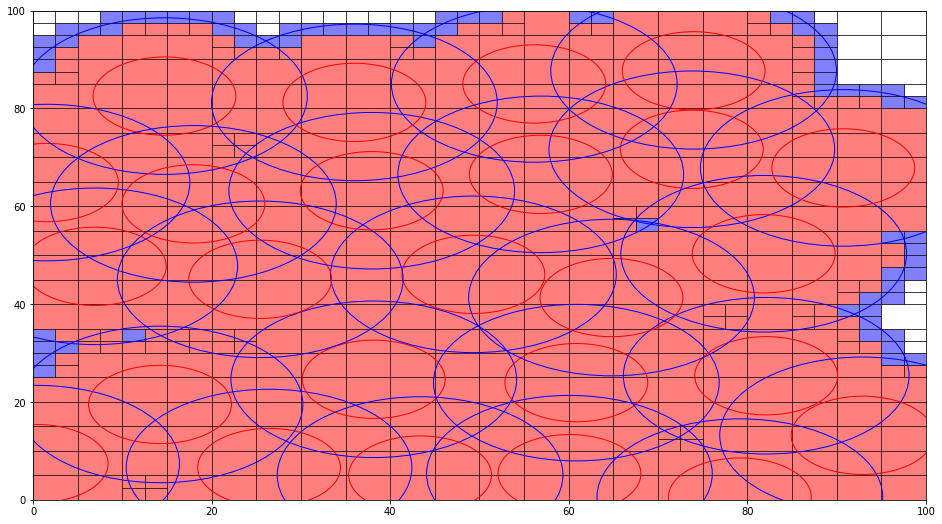

0.004 98 count 4 trials 1000


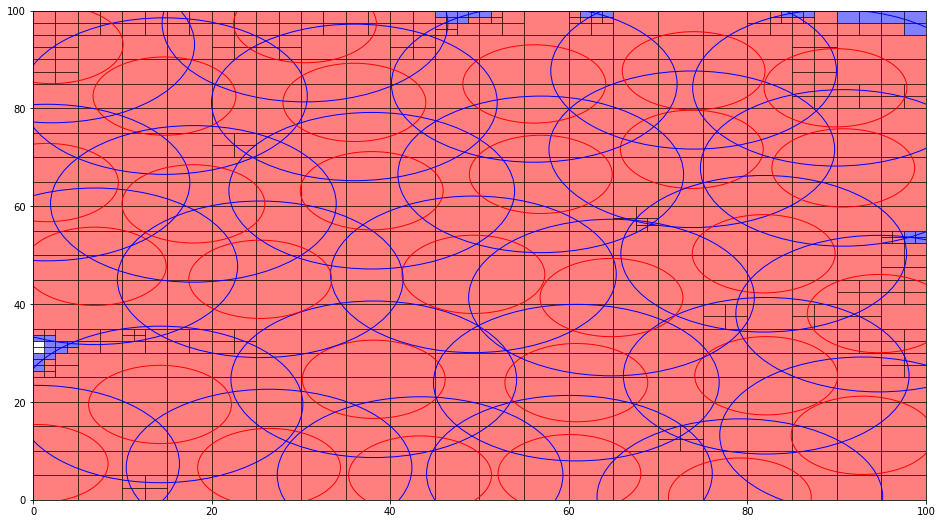

0.001 195 count 1 trials 1000


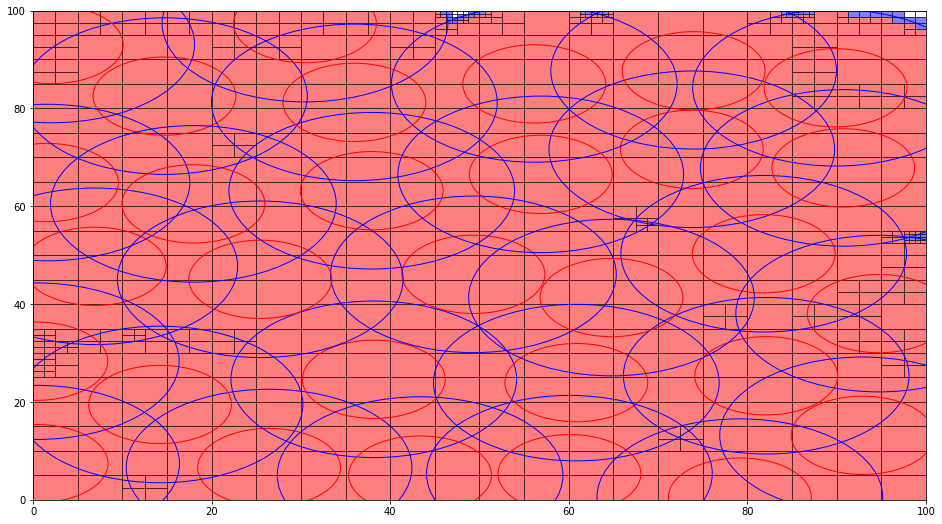

0.0 498 count 0 trials 1000


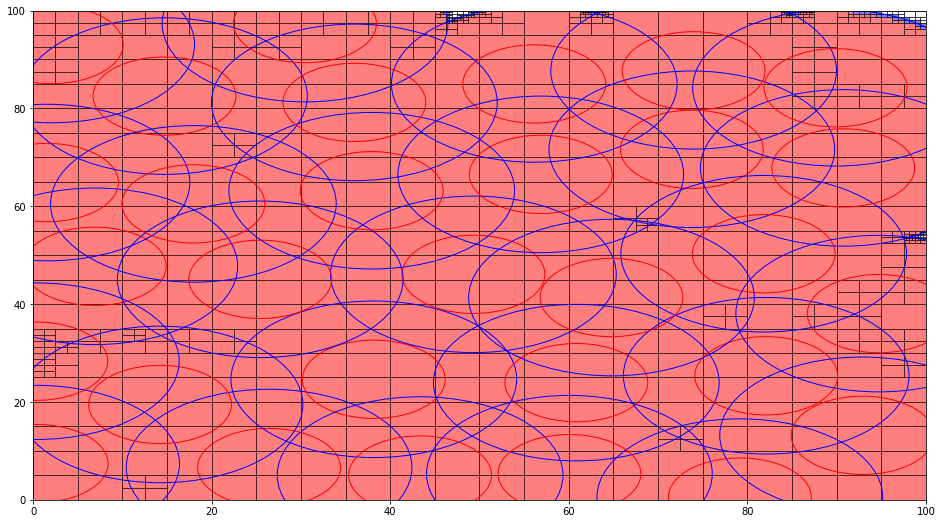

0.0 1563 count 0 trials 1000


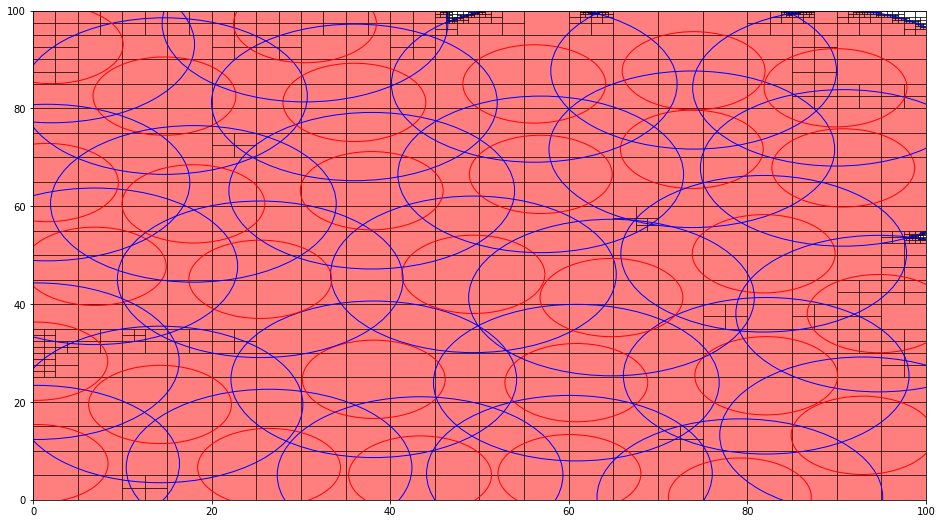

0.0 5491 count 0 trials 1000


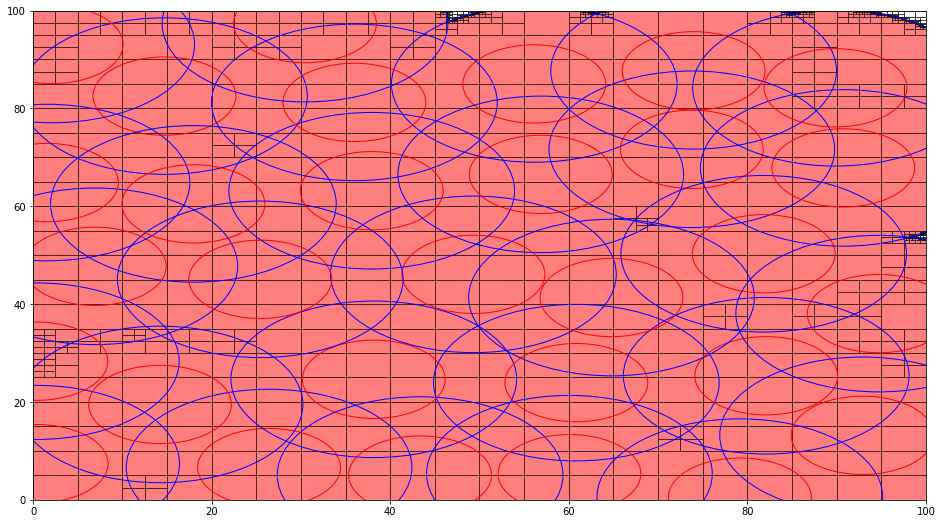

0.0 20946 count 0 trials 1000


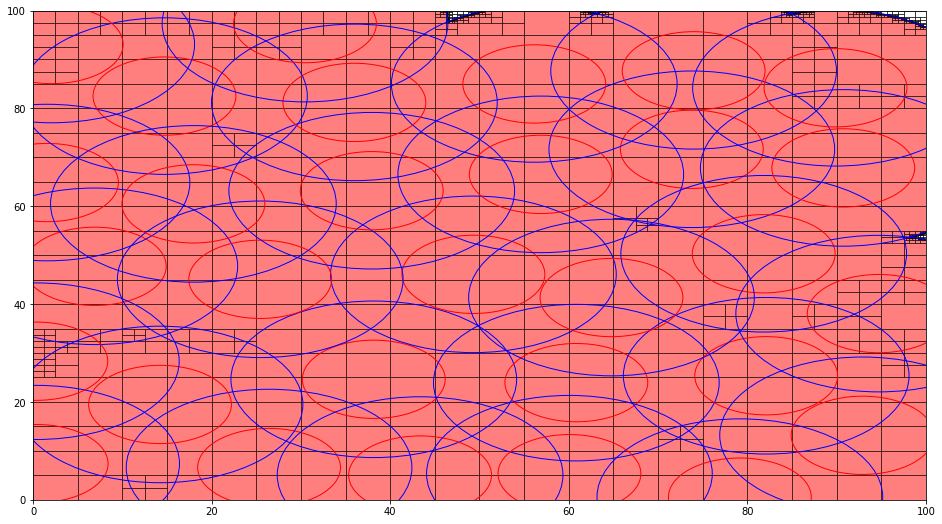

0.0 80061 count 0 trials 1000


KeyboardInterrupt: 

In [7]:
world = RSAWorld((100.0,100.0),(20,20),RSAVoxel,CircleFigure) 
world.perform_rsa(0.1,1000)

#for i in range(2):
#    voxel = world.get_final_voxel_from_pos((61.0,81.0))
#    voxel.subdivide()
#for i in range(20):
#    world.add_random_figure()    
world.plot()
#TODO:
# fix voxel_overlap

In [ ]:
l = ["a","b","c"]
while len(l) > 0:
    print(l.pop())